# Data Pipeline

This notebook describes the pipeline for milestone 3 for our project. It should give an overview of how we intend to load, clean, parse and exploit our data for our story telling.

## Imports

In [2]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from collections import defaultdict

# Loading and cleaning the data

Given the data size, pandas dataframe will be used.

## Handling data

In [3]:
CHARACTER_DATA_PATH = './data/character.metadata.tsv'
MOVIE_DATA_PATH = './data/movie.metadata.tsv'
SUMMARIES_DATA_PATH = './data/plot_summaries.txt'
NAME_DATA_PATH = './data/name.clusters.txt'
TYPE_DATA_PATH = './data/tvtropes.clusters.txt'

## Characters data

In [4]:
CHARACTER_HEADER = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_name',
                    'Actor_date_of_birth','Actor_gender','Actor_height','Actor_ethnicity','Actor_name',
                    'Actor_age_at_movie_release','Freebase_character/actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
character = pd.read_table(CHARACTER_DATA_PATH,header=None,names=CHARACTER_HEADER)

In [5]:
character.describe()

,Wikipedia_movie_ID,Actor_height,Actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


First, we want to clean the dataset :
- negative ages should be removed
- actor's height > 2.5 as well, as they become irrelevant compared to the true height of actors
- dates converted to correct format

In [6]:
character['Actor_age_at_movie_release'] = character['Actor_age_at_movie_release'].apply(lambda x: np.nan if x < 0 else x)
character['Actor_height'] = character['Actor_height'].apply(lambda x: np.nan if x > 2.5 else x)
character['Movie_release_date'] = pd.to_datetime(character['Movie_release_date'],format='mixed',utc=True,errors='coerce')
character['Actor_date_of_birth'] = pd.to_datetime(character['Actor_date_of_birth'],format='mixed',utc=True,errors='coerce')
character.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
281373,1194710,/m/04g9gd,2005-09-25 00:00:00+00:00,Burke Beckett,1965-03-24 00:00:00+00:00,M,1.68,NaN,Peter Jacobson,40.0,/m/0cg4x_x,/m/0gz6143,/m/02wcx8c
80246,24730123,/m/08087rw,1993-01-01 00:00:00+00:00,NaN,NaT,NaN,NaN,NaN,Bokhodur Djurabajev,NaN,/m/0bhgqvw,NaN,/m/0bhgqvt
233290,9366283,/m/028637h,1968-01-01 00:00:00+00:00,NaN,1910-03-01 00:00:00+00:00,M,1.83,/m/03lmx1,David Niven,57.0,/m/02vb75m,NaN,/m/0f2df
270208,2421498,/m/07bxvv,1987-01-01 00:00:00+00:00,NaN,NaT,NaN,NaN,NaN,Ira Wheeler,NaN,/m/0cfz_5z,NaN,/m/0bvc791
430568,525305,/m/02lk42,2004-04-21 00:00:00+00:00,Jorge Ramirez,1960-02-05 00:00:00+00:00,M,NaN,NaN,Mario Zaragoza,44.0,/m/0cjcwhc,/m/0cjcwhg,/m/04nrwsl


## TODO
Should modify the ethnicityto give corresponding freebase ID. https://pypi.org/project/freebase/

### Movies data

In [7]:
MOVIE_HEADER = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date',
                'Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']

movie = pd.read_table(MOVIE_DATA_PATH,header=None,names=MOVIE_HEADER)


In [8]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


The next cell will transform the dictionaries we might find in the cells of our data frames into comma-separated strings.

In [9]:
def format_dict(x):
    n = len(x)
    if n==0:
        return np.nan
    else:
        return list(x.values())
    

try :

    movie['Movie_genres'] = movie['Movie_genres'].apply(json.loads).apply(format_dict)
    movie['Movie_countries'] = movie['Movie_countries'].apply(json.loads).apply(format_dict)
    movie['Movie_languages'] = movie['Movie_languages'].apply(json.loads).apply(format_dict)
except TypeError:
    print('Data has already been parsed and modified.')



There is a bit of cleaning to perform :
- we will focus on movies whose runtime is < 15000, because that is the longest movie we found to have its true length.
- dates to correct format

In [10]:
movie['Movie_runtime'] = movie['Movie_runtime'].apply(lambda x: np.nan if 1 > x or x > 15000 else x)
movie['Movie_release_date'] = pd.to_datetime(movie['Movie_release_date'],format='mixed',utc=True,errors='coerce')
movie.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
69682,25903505,/m/0b6d459,Chalo America,1999-08-01 00:00:00+00:00,NaN,93.0,NaN,[India],[Comedy]
55197,3745465,/m/09yqrb,Hellraiser: Hellseeker,2002-01-01 00:00:00+00:00,NaN,89.0,[English Language],[United States of America],"[Thriller, Horror, Supernatural, Cult, Mystery..."
40029,20904519,/m/05b0qng,Aur Kaun?,NaT,NaN,NaN,[Hindi Language],[India],[Horror]
27241,447194,/m/029jt9,Samson and Delilah,1949-12-21 00:00:00+00:00,11000000.0,131.0,[English Language],[United States of America],"[History, Romance Film, Action, Drama, Adventure]"
23247,28764263,/m/0dd9zb6,Lo chiameremo Andrea,1972-10-14 00:00:00+00:00,NaN,100.0,NaN,[Italy],[Comedy film]


In [11]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,61233.000000
mean,1.740784e+07,4.799363e+07,94.298795
std,1.098791e+07,1.121753e+08,91.294848
min,3.300000e+02,1.000000e+04,1.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,14400.000000


## Summaries data

In [12]:
summaries = pd.read_table(SUMMARIES_DATA_PATH,header=None,names=['Wikipedia_movie_ID','Summary'])
summaries.head()

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Character names data

In [13]:
name = pd.read_table(NAME_DATA_PATH,header=None,names=['Character_name','Freebase_character/actor_map_ID'])
name.head()

,Character_name,Freebase_character/actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


## Character types data

In [14]:
character_type = pd.read_table(TYPE_DATA_PATH,header=None,names=['Character_type','Instance'])
character_type = pd.concat([character_type, character_type['Instance'].apply(json.loads).apply(pd.Series)], axis=1)
character_type.drop(columns='Instance',inplace=True)
character_type.rename(columns={'char': 'Character_name','movie': 'Movie_name','id': 'Freebase_character/actor_map_ID',
                               'actor': 'Actor_name'},inplace=True)
character_type.head()

,Character_type,Character_name,Movie_name,Freebase_character/actor_map_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


# Visualizing data

Here a few visualiztions are provided to get a glimpse of the data.

## Characters dataset

c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

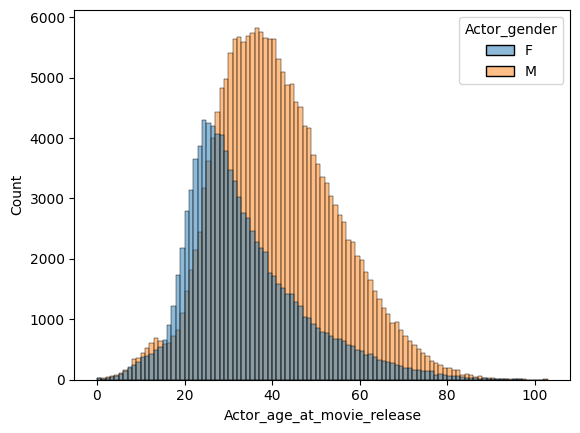

In [15]:
sns.histplot(data=character,x='Actor_age_at_movie_release',hue='Actor_gender',binwidth=1);

c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

(1.4, 2.1)

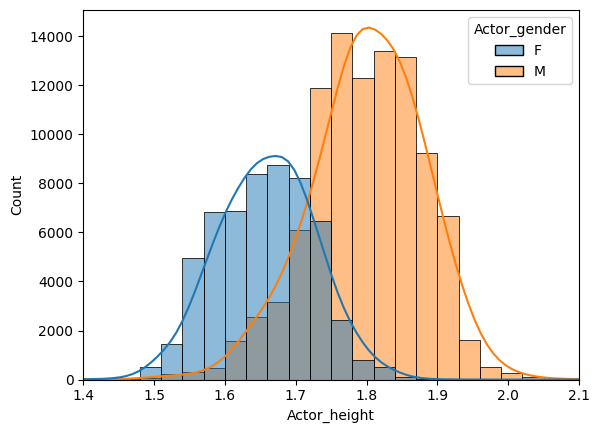

In [16]:
sns.histplot(data=character,x='Actor_height',hue='Actor_gender',binwidth=0.03,kde=True,kde_kws={'bw_adjust':3})
plt.xlim([1.4,2.1])

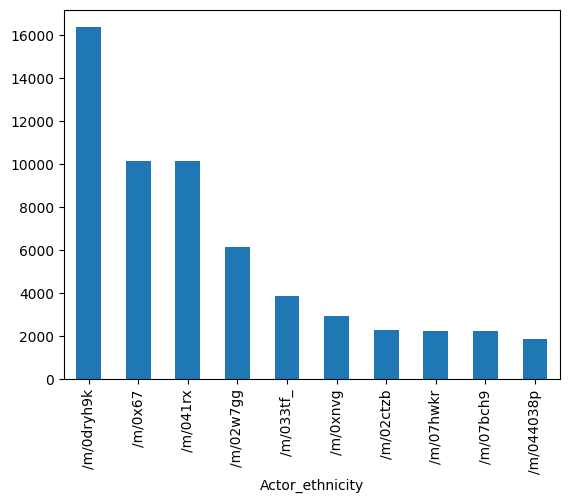

In [17]:
character['Actor_ethnicity'].value_counts().head(10).plot(kind='bar');

## Movies dataset

c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


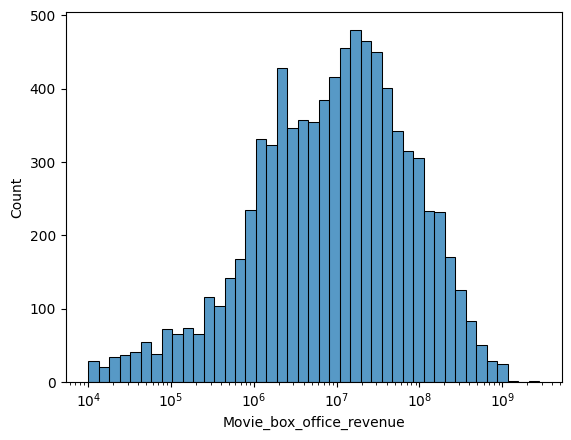

In [18]:
sns.histplot(data=movie,x='Movie_box_office_revenue',log_scale=True);

The spike around $ 1 million is weird, must be investigated.

c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


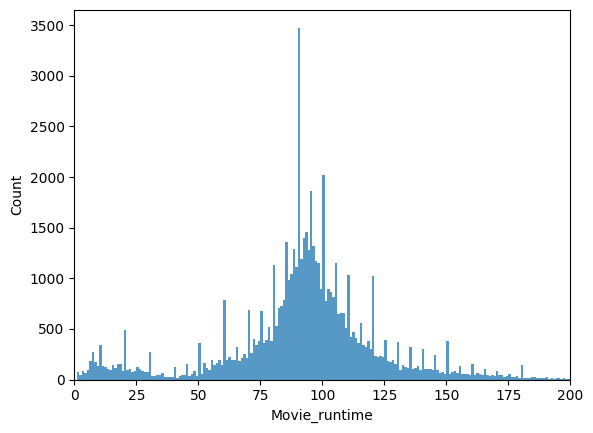

In [19]:
sns.histplot(data=movie,x='Movie_runtime',binwidth=1);
plt.xlim([0,200]);

- Lots of movie of 90 min

c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


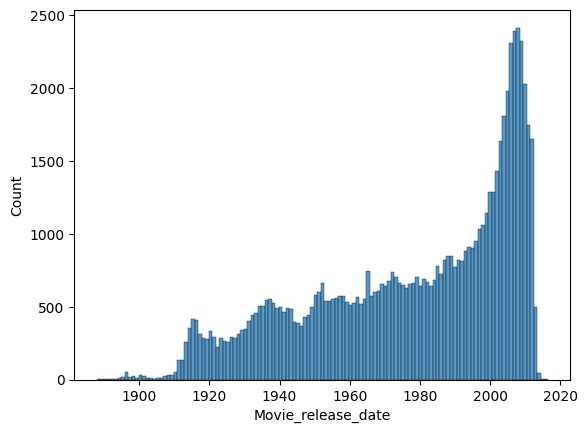

In [20]:
sns.histplot(data=movie,x='Movie_release_date', bins=(max(movie.Movie_release_date).year - min(movie.Movie_release_date).year + 1));

c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


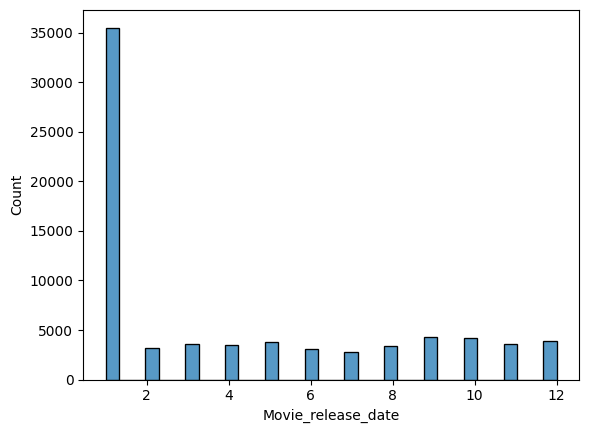

In [21]:
sns.histplot(movie['Movie_release_date'].apply(lambda x: x.month));

- Because of `pd.to_datetime` which converts to the first day of the year a date with only the year indicated
- If monthly or daily analysis wanted, use `format = "%Y-%m-%d"`as argument of `pd.to_datetime`

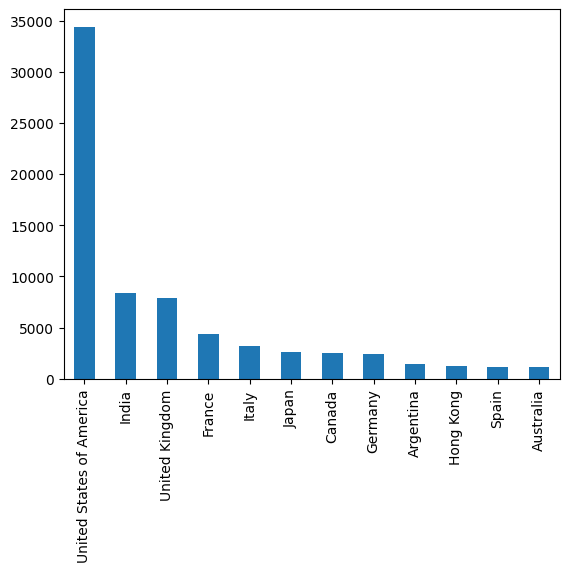

In [22]:
movie_countries= movie['Movie_countries'].apply(lambda x: pd.Series(x).value_counts()).sum().sort_values(ascending=False)
movie_countries.loc[movie_countries.values>=1000].plot(kind='bar');

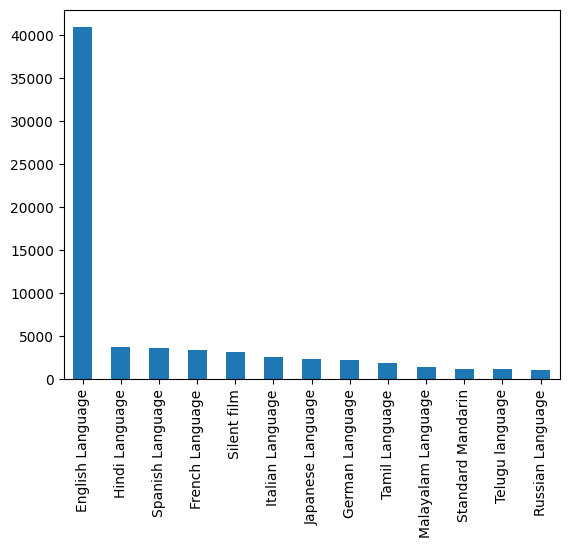

In [23]:
movie_language = movie['Movie_languages'].apply(lambda x: pd.Series(x).value_counts()).sum().sort_values(ascending=False)
movie_language.loc[movie_language.values>=1000].plot(kind='bar');

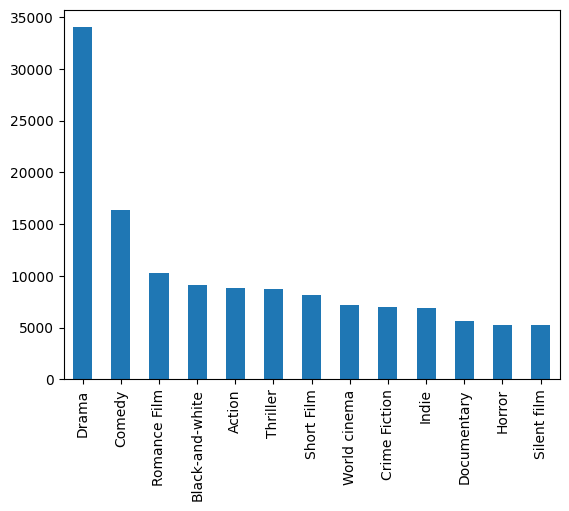

In [24]:
movie_genres = movie['Movie_genres'].apply(lambda x: pd.Series(x).value_counts()).sum().sort_values(ascending=False)
movie_genres.loc[movie_genres.values>=5000].plot(kind='bar');

## Names of characters dataset

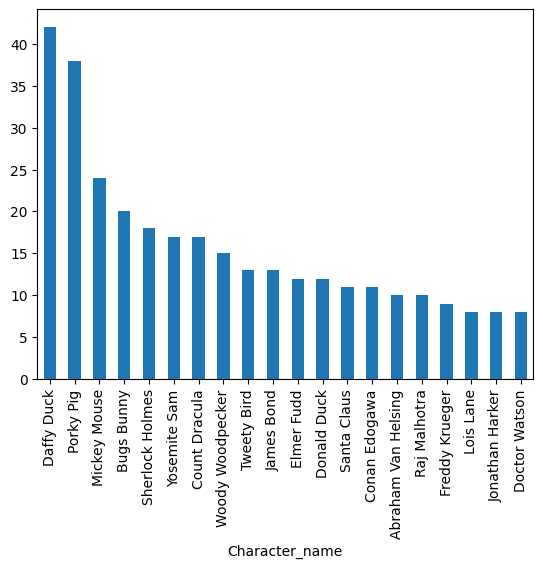

In [25]:
name['Character_name'].value_counts().head(20).plot(kind='bar');

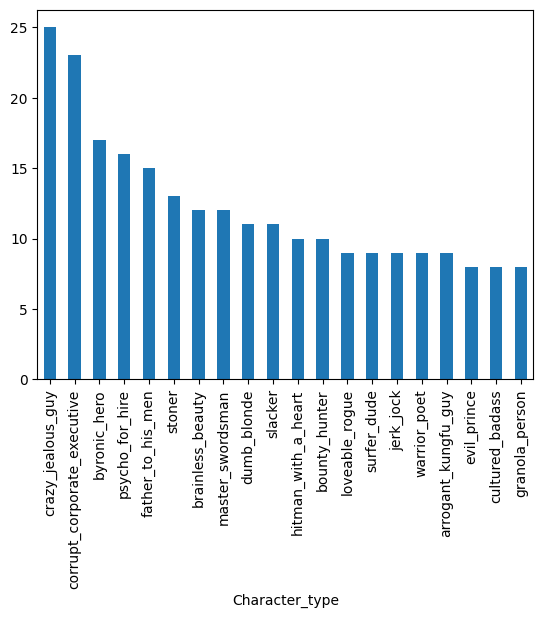

In [26]:
character_type['Character_type'].value_counts().head(20).plot(kind='bar');

# Data processing pipeline and story telling

The purpose of the data gathering is to tell a story. 

### Actor analysis

We want to perform mainly two analysis to analyse if Hollywood gives its chance to new actors and is innovative.
- The first thing is a time series analysis overt time of actors roles
- The second thing is an analysis of the roles played throughout actors careers, this is something very important for a newcomer as he can be categorized because of the first roles he had

We display the two dataframes that will be used in this analysis.

In [45]:
character.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Akooshay,1958-08-26 00:00:00+00:00,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Lieutenant Melanie Ballard,1974-08-15 00:00:00+00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Desolation Williams,1969-06-15 00:00:00+00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Sgt Jericho Butler,1967-09-12 00:00:00+00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24 00:00:00+00:00,Bashira Kincaid,1977-09-25 00:00:00+00:00,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [46]:
character_type.head()

,Character_type,Character_name,Movie_name,Freebase_character/actor_map_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [47]:
# Sort the DataFrame by 'Fb_actor_id', 'Actor_age', and 'Character'
character_df = character.sort_values(['Freebase_actor_ID', 'Actor_age_at_movie_release', 'Character_name'])

# Create a mask to identify the major roles (Character is not NaN)
major_role_mask = character_df['Character_name'].notna()

# Calculate the i-th film for each actor based on major roles
character_df['Film_Index'] = (major_role_mask.groupby(character_df['Freebase_actor_ID']).cumsum()
                    .where(major_role_mask, np.nan))  # Set 0 for minor roles

#Display the first roles played by Johnny Depp
stat = character_df[character_df['Actor_name']== "Johnny Depp"]
stat.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Film_Index
120977,3028191,/m/08ll52,1984-11-09 00:00:00+00:00,Glen Lantz,1963-06-09 00:00:00+00:00,M,1.78,/m/01qhm_,Johnny Depp,21.0,/m/0jsvh6,/m/0csqbm,/m/0jfx1,1.0
351263,3514297,/m/09hq9g,1985-04-10 00:00:00+00:00,Jack,1963-06-09 00:00:00+00:00,M,1.78,/m/01qhm_,Johnny Depp,21.0,/m/03lfl4k,/m/04fll8n,/m/0jfx1,2.0
22381,19315787,/m/04lgx5r,1986-06-29 00:00:00+00:00,Donnie Fleischer,1963-06-09 00:00:00+00:00,M,1.78,/m/01qhm_,Johnny Depp,23.0,/m/04q4cj_,/m/0gxq38m,/m/0jfx1,3.0
229949,113460,/m/0sxmx,1986-12-19 00:00:00+00:00,Gator Lerner,1963-06-09 00:00:00+00:00,M,1.78,/m/01qhm_,Johnny Depp,23.0,/m/0k1yz8,/m/02nwky0,/m/0jfx1,4.0
441458,6614818,/m/0gdv4x,1989-01-01 00:00:00+00:00,NaN,1963-06-09 00:00:00+00:00,M,1.78,/m/01qhm_,Johnny Depp,25.0,/m/0h9hhm2,NaN,/m/0jfx1,NaN


#### We can study if the movie industry give their chance to new actors throughout time 
We know that this process is not relevant for the first years of the dataset as all the actors will be new.

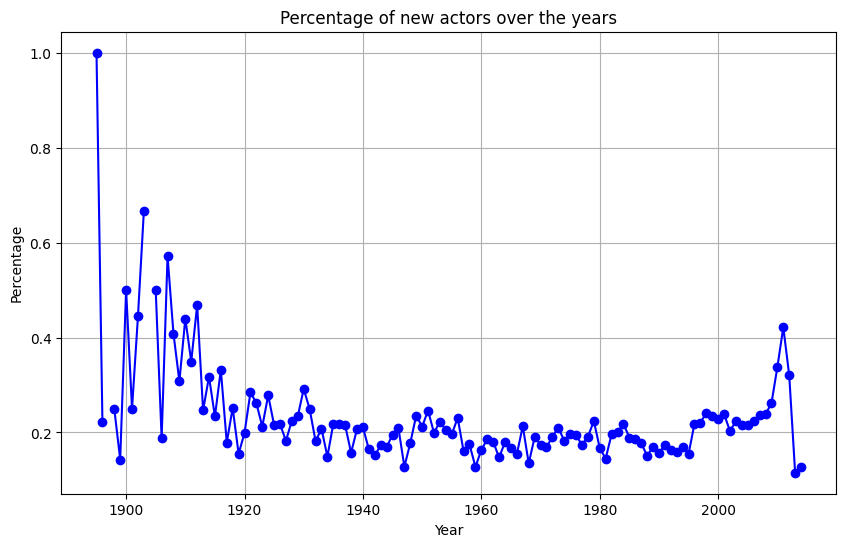

In [52]:
# Filter major roles (Character is not NaN)
major_roles = character_df[character_df['Character_name'] != 'NaN']
# Only keep the year from the release date
major_roles['release_date'] = major_roles['Movie_release_date'].dt.year

# Group by release date and calculate the number of actors with Film_Index equal to 1 or higher
actors_by_year = major_roles.groupby('release_date')['Freebase_actor_ID'].nunique()

# Group by release date and calculate the number of actors with Film_Index equal to 1
actors_with_index_1_by_year = major_roles[major_roles['Film_Index'] == 1].groupby('release_date')['Freebase_actor_ID'].nunique()

# Calculate the ratio of actors with Film_Index 1 to actors with Film_Index 1 or higher for each year
ratio = actors_with_index_1_by_year / actors_by_year

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(ratio.index, ratio, marker='o', linestyle='-', color='b')
plt.title('Percentage of new actors over the years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.show()

#### A Markov Chain to know how actors transtion from one role to another

In [58]:
# Perform an outer merge to retain all rows
merged_data = character_df.merge(character_type, left_on=['Freebase_character/actor_map_ID', 'Character_name'], right_on=['Freebase_character/actor_map_ID', 'Character_name'], how='outer')
# Drop the specified columns
merged_data.drop(columns=['Actor_name_y', 'Character_name', 'Movie_name'], inplace=True)

# Drop rows with NaN values in the 'CharType' column
merged_data.dropna(subset=['Character_type'], inplace=True)
# Display the merged data
print(merged_data.shape)
merged_data.head()

(501, 14)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name_x,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Film_Index,Character_type
680,2087781,/m/06l9q0,1985-07-10 00:00:00+00:00,1955-01-18 00:00:00+00:00,M,1.850,/m/09vc4s,Kevin Costner,30.0,/m/0k39jj,/m/0g_vt8w,/m/0127m7,5.0,young_gun
1720,142430,/m/011yhm,1996-03-08 00:00:00+00:00,1953-08-27 00:00:00+00:00,M,1.892,/m/065b6q,Peter Stormare,42.0,/m/0jy2x0,/m/04mn0r0,/m/012q4n,1.0,psycho_for_hire
2053,598397,/m/02t_h3,2004-03-29 00:00:00+00:00,1970-02-14 00:00:00+00:00,M,1.780,NaN,Simon Pegg,34.0,/m/0k35n0,/m/0gxnhy3,/m/012x2b,6.0,slacker
2062,8172248,/m/026rrf_,2007-09-07 00:00:00+00:00,1970-02-14 00:00:00+00:00,M,1.780,NaN,Simon Pegg,37.0,/m/03lvx8n,/m/0gxnhw4,/m/012x2b,15.0,loser_protagonist
2065,14280823,/m/03c_4fq,2008-10-03 00:00:00+00:00,1970-02-14 00:00:00+00:00,M,1.780,NaN,Simon Pegg,38.0,/m/040l_q8,/m/0gxnhyk,/m/012x2b,18.0,loser_protagonist


In [66]:
#Need to be done more carefully, using maybe Word2vec maybe ask the TA
CHAR_MAPPING = {
    'absent_minded_professor': 'Intellectuals',
    'adventurer_archaeologist': 'Adventurers',
    'arrogant_kungfu_guy': 'Warriors and Fighters',
    'big_man_on_campus': 'Leadership and Authority',
    'bounty_hunter': 'Adventurers',
    'brainless_beauty': 'Comedic and Eccentric',
    'broken_bird': 'Quirky and Unique',
    'bromantic_foil': 'Comedic and Eccentric',
    'bruiser_with_a_soft_center': 'Antiheroes',
    'bully': 'Villains',
    'byronic_hero': 'Antiheroes',
    'casanova': 'Lovers and Romantics',
    'chanteuse': 'Intellectuals',
    'charmer': 'Lovers and Romantics',
    'child_prodigy': 'Intellectuals',
    'classy_cat_burglar': 'Villains',
    'consummate_professional': 'N/A',
    'corrupt_corporate_executive': 'Villains',
    'coward': 'Antiheroes',
    'crazy_jealous_guy': 'Villains',
    'crazy_survivalist': 'Quirky and Unique',
    'cultured_badass': 'Warriors and Fighters',
    'dean_bitterman': 'Leadership and Authority',
    'dirty_cop': 'Villains',
    'ditz': 'Comedic and Eccentric',
    'doormat': 'N/A',
    'drill_sargeant_nasty': 'Leadership and Authority',
    'dumb_blonde': 'Comedic and Eccentric',
    'dumb_muscle': 'Warriors and Fighters',
    'eccentric_mentor': 'Intellectuals',
    'egomaniac_hunter': 'Villains',
    'evil_prince': 'Villains',
    'fastest_gun_in_the_west': 'Warriors and Fighters',
    'father_to_his_men': 'Leadership and Authority',
    'final_girl': 'Classic Heroic Figures',
    'gadgeteer_genius': 'Intellectuals',
    'gentleman_thief': 'Villains',
    'granola_person': 'N/A',
    'grumpy_old_man': 'Quirky and Unique',
    'hardboiled_detective': 'Antiheroes',
    'heartbroken_badass': 'Antiheroes',
    'henpecked_husband': 'Comedic and Eccentric',
    'hitman_with_a_heart': 'Antiheroes',
    'jerk_jock': 'Leadership and Authority',
    'junkie_prophet': 'Quirky and Unique',
    'klutz': 'Comedic and Eccentric',
    'loser_protagonist': 'Antiheroes',
    'loveable_rogue': 'Lovers and Romantics',
    'master_swordsman': 'Warriors and Fighters',
    'morally_bankrupt_banker': 'Villains',
    'officer_and_a_gentleman': 'Leadership and Authority',
    'ophelia': 'Tragic Figures',
    'playful_hacker': 'N/A',
    'prima_donna': 'Comedic and Eccentric',
    'psycho_for_hire': 'Villains',
    'pupil_turned_to_evil': 'Villains',
    'retired_outlaw': 'Villains',
    'revenge': 'Villains',
    'romantic_runnerup': 'Lovers and Romantics',
    'self_made_man': 'Antiheroes',
    'slacker': 'Antiheroes',
    'stoner': 'Antiheroes',
    'storyteller': 'Intellectuals',
    'stupid_crooks': 'Comedic and Eccentric',
    'surfer_dude': 'Adventurers',
    'the_chief': 'Leadership and Authority',
    'the_editor': 'Quirky and Unique',
    'tranquil_fury': 'Warriors and Fighters',
    'trickster': 'Comedic and Eccentric',
    'valley_girl': 'Comedic and Eccentric',
    'warrior_poet': 'Warriors and Fighters',
    'young_gun': 'Classic Heroic Figures'
}
#Then we filter the dataframe
# Add a new column 'Category' to your DataFrame based on the 'CharType' column
merged_data['Category'] = merged_data['Character_type'].map(CHAR_MAPPING)
reduced_df = merged_data[['Actor_gender','Category','Actor_age_at_movie_release','Movie_release_date','Film_Index','Freebase_character/actor_map_ID','Actor_name_x']]
reduced_df

,Actor_gender,Category,Actor_age_at_movie_release,Movie_release_date,Film_Index,Freebase_character/actor_map_ID,Actor_name_x
680,M,Classic Heroic Figures,30.0,1985-07-10 00:00:00+00:00,5.0,/m/0k39jj,Kevin Costner
1720,M,Villains,42.0,1996-03-08 00:00:00+00:00,1.0,/m/0jy2x0,Peter Stormare
2053,M,Antiheroes,34.0,2004-03-29 00:00:00+00:00,6.0,/m/0k35n0,Simon Pegg
2062,M,Antiheroes,37.0,2007-09-07 00:00:00+00:00,15.0,/m/03lvx8n,Simon Pegg
2065,M,Antiheroes,38.0,2008-10-03 00:00:00+00:00,18.0,/m/040l_q8,Simon Pegg
...,...,...,...,...,...,...,...
449277,M,Antiheroes,21.0,1982-08-13 00:00:00+00:00,2.0,/m/0jy30b,Sean Penn
449278,M,Adventurers,21.0,1982-08-13 00:00:00+00:00,2.0,/m/0jy30b,Sean Penn
449331,M,Villains,36.0,1984-06-29 00:00:00+00:00,9.0,/m/0jwmfk,Arnold Schwarzenegger
449794,M,Lovers and Romantics,53.0,1991-02-14 00:00:00+00:00,31.0,/m/0k6g86,Anthony Hopkins


In [69]:
# Group the data by actor name and sort by movie release date
grouped = reduced_df.groupby('Actor_name_x').apply(lambda x: x.sort_values('Movie_release_date'))

# Initialize a transition probability matrix
categories = reduced_df['Category'].unique()
transition_matrix = pd.DataFrame(0, columns=categories, index=categories, dtype=float)

# Calculate transition probabilities
for actor, actor_data in grouped.groupby(level=0):
    previous_category = None
    for _, row in actor_data.iterrows():
        current_category = row['Category']
        if previous_category is not None:
            transition_matrix.at[previous_category, current_category] += 1
        previous_category = current_category

# Normalize to get transition probabilities
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

categories_to_drop = ['Classic Heroic Figures', 'Tragic Figures']

# Drop rows and columns with categories to drop
transition_matrix = transition_matrix.drop(index=categories_to_drop, columns=categories_to_drop)
# Print the transition probability matrix
transition_matrix

,Villains,Antiheroes,Adventurers,N/A,Comedic and Eccentric,Quirky and Unique,Lovers and Romantics,Intellectuals,Warriors and Fighters,Leadership and Authority
Villains,0.363636,0.090909,0.045455,0.000000,0.000000,0.136364,0.045455,0.090909,0.090909,0.136364
Antiheroes,0.150000,0.450000,0.100000,0.000000,0.075000,0.000000,0.125000,0.000000,0.075000,0.025000
Adventurers,0.000000,0.200000,0.500000,0.100000,0.000000,0.000000,0.100000,0.000000,0.100000,0.000000
N/A,0.200000,0.200000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000
Comedic and Eccentric,0.000000,0.217391,0.043478,0.000000,0.521739,0.043478,0.043478,0.043478,0.043478,0.043478
Quirky and Unique,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Lovers and Romantics,0.000000,0.230769,0.000000,0.000000,0.153846,0.000000,0.230769,0.076923,0.307692,0.000000
Intellectuals,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667
Warriors and Fighters,0.176471,0.352941,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.176471,0.176471
Leadership and Authority,0.307692,0.000000,0.000000,0.000000,0.076923,0.000000,0.153846,0.000000,0.153846,0.307692


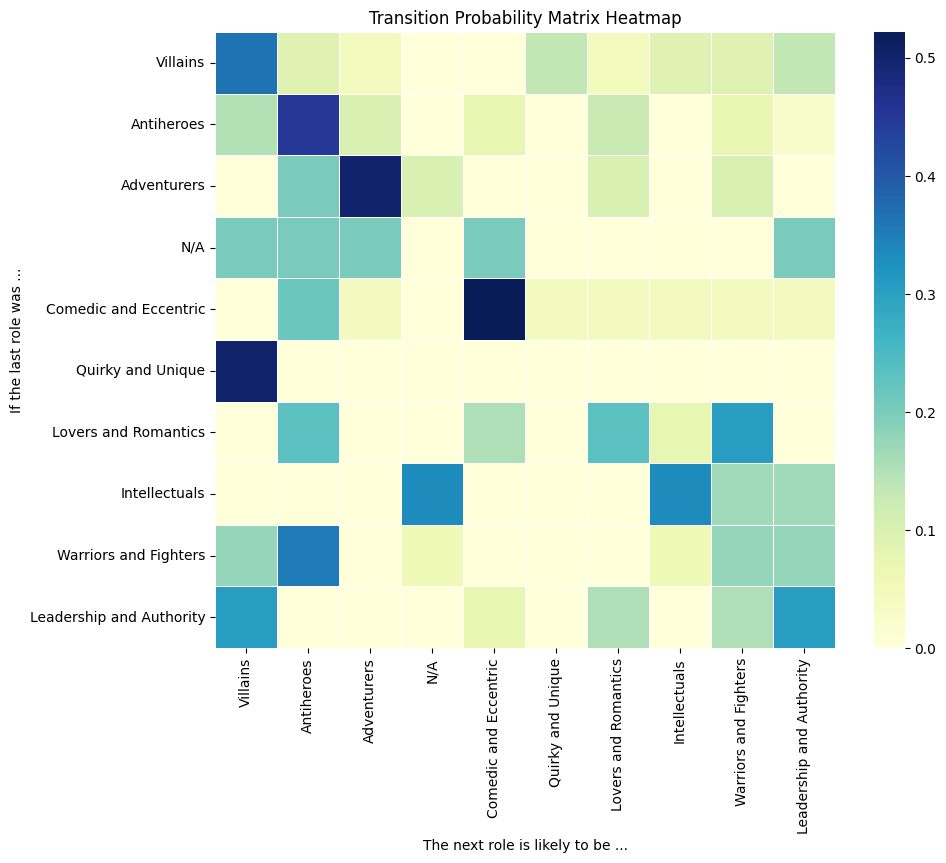

In [73]:
plt.figure(figsize=(10, 8))

# Create the heatmap without annotations for the first row
sns.heatmap(transition_matrix, cmap="YlGnBu", annot=False, cbar=True, linewidths=0.5)

# Set axis labels and plot title
plt.xlabel("The next role is likely to be ...")
plt.ylabel("If the last role was ...")
plt.title("Transition Probability Matrix Heatmap")

# Display the heatmap
plt.show()